In [1]:
import os
import sys
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
import geopandas as gpd
from rasterio.warp import reproject, Resampling

import rasterio.mask
from rasterio.mask import mask


from rasterio.features import rasterize
from rasterio.transform import from_origin
import fiona
from rasterio import features
from rasterio.plot import show
from scipy.ndimage import distance_transform_edt

In [2]:
# Get the current working directory
current_dir = os.path.abspath('')

# Search for the 'constants.py' file starting from the current directory and moving up the hierarchy
project_root = current_dir
while not os.path.isfile(os.path.join(project_root, 'constants.py')):
    project_root = os.path.dirname(project_root)

# Add the project root to the Python path
sys.path.append(project_root)

In [3]:
from constants import MODIFIED_RASTER, GRUPO_RASTER, DATA_PATH, CROPPED_HANSEN_TEN_MASK, HANSEN_TREECOVER_FILEPATH, SOIL, DISSOLVED_CLEAN_YEAR, TREECOVER_10_AND_ABOVE, SOIL


<Axes: >

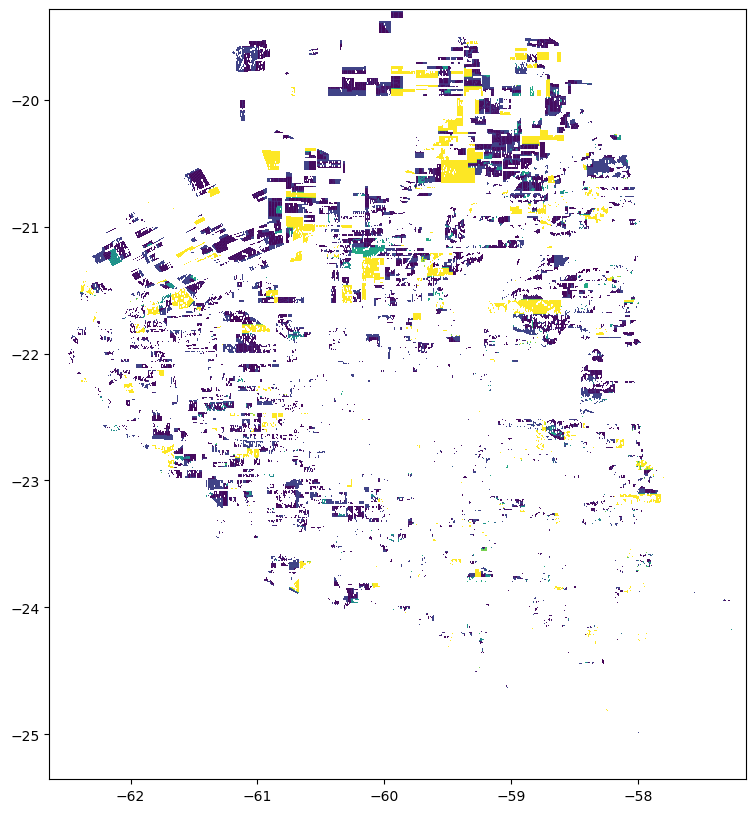

In [4]:
lup_raster = rasterio.open(r"C:\Users\bsf31\Documents\post-meds\data\policy-data\ml_data\grupo_masked.tif")
# Read the raster data into a NumPy array
lup_raster_array = lup_raster.read(1)
# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(lup_raster, ax = ax)
plt.gca()

In [5]:
ROAD_PATH = r"C:\Users\bsf31\Documents\post-meds\data\policy-data\py-data\infona_data-20240223T131213Z-001\infona_data\dissolved_road\dissolved_road.gpkg"

In [6]:
raster_path =  r"C:\Users\bsf31\Documents\post-meds\data\policy-data\ml_data\binary_deforestation_raster.tif"

In [7]:
# Read in vector
vector = gpd.read_file(ROAD_PATH).to_crs("EPSG:4326")

# Get list of geometries for all features in vector file
geom = [shapes for shapes in vector.geometry]


<Axes: >

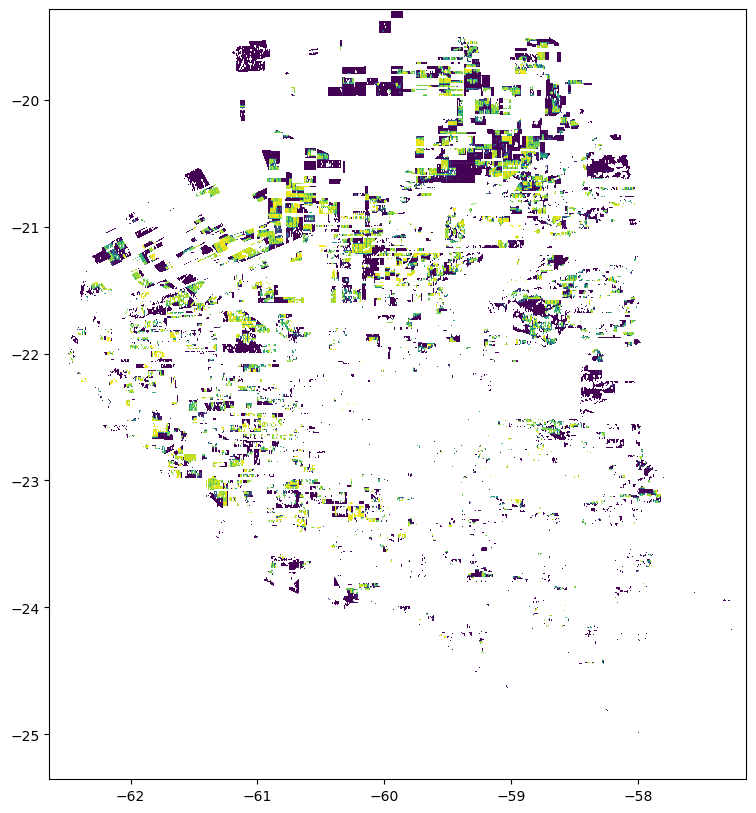

In [8]:
raster = rasterio.open(raster_path)

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(raster, ax = ax)
plt.gca()

In [10]:
# Rasterize vector using the shape and coordinate system of the raster
rasterized = features.rasterize(geom,
                                out_shape = raster.shape,
                                fill = -1,
                                out = None,
                                transform = raster.transform,
                                all_touched = False,
                                default_value = 1,
                                dtype = None)

In [14]:
output_dir = os.path.join(DATA_PATH, 'processed_rasters', 'road_raster')
os.makedirs(output_dir, exist_ok=True)
output_filepath = os.path.join(output_dir, 'road_raster.tif')

In [15]:
profile = raster.profile

# Write the rasterized data to a new GeoTIFF file
with rasterio.open(output_filepath, 'w', **profile) as dst:
    dst.write(rasterized.astype('int16'), 1)

In [23]:
# Convert the rasterized array to boolean where True represents roads
road_mask = rasterized == 1

# Convert the lup_raster array to boolean where True represents the area of interest
area_mask = np.isin(lup_raster_array, [1, 2, 3, 4,5,6])

# Calculate the Euclidean distance from each road pixel to every other pixel
distances = distance_transform_edt(~road_mask)

# For pixels outside the area of interest, set the distance to a nodata value
distances[~area_mask] = -1

In [21]:
print(np.sum(road_mask) / road_mask.size)


0.0055217169425639855


In [24]:
print(np.sum(area_mask) / area_mask.size)


0.18349006638532403


In [22]:
unique_values = np.unique(lup_raster)
print(unique_values)


[<open DatasetReader name='C:/Users/bsf31/Documents/post-meds/data/policy-data/ml_data/grupo_masked.tif' mode='r'>]


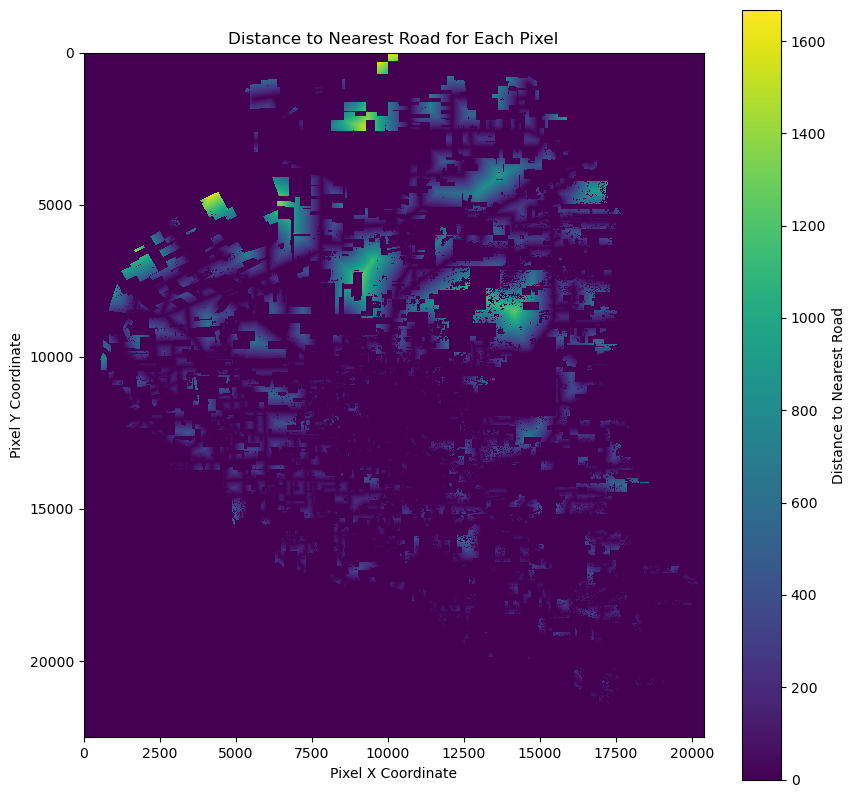

In [25]:
# Plot the distances array
plt.figure(figsize=(10, 10))
plt.imshow(distances, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Distance to Nearest Road')
plt.title('Distance to Nearest Road for Each Pixel')
plt.xlabel('Pixel X Coordinate')
plt.ylabel('Pixel Y Coordinate')
plt.show()

In [29]:
output_dir = os.path.join(DATA_PATH, 'ml_data')
os.makedirs(output_dir, exist_ok=True)
output_filepath = os.path.join(output_dir, 'road_distance_raster.tif')

In [30]:

# Write the rasterized data to a new GeoTIFF file
with rasterio.open(output_filepath, 'w', **profile) as dst:
    dst.write(distances.astype('int16'), 1)

# Distance to River

In [9]:
# Modify the nodata value and the data type in the raster profile
profile = raster.profile
profile.update(nodata=-1, dtype='float32')

profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1, 'width': 20381, 'height': 22512, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -62.64186038139295,
       0.0, -0.00026949458523585647, -19.287457970745013), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

In [10]:
# Read in vector
vector_river = gpd.read_file(r"C:\Users\bsf31\Documents\post-meds\data\policy-data\py-data\infona_data-20240223T131213Z-001\infona_data\river_buffer\river_buffer.gpkg").to_crs("EPSG:4326")

# Get list of geometries for all features in vector file
geom_river = [shapes for shapes in vector_river.geometry]

In [11]:
# Rasterize vector using the shape and coordinate system of the raster
rasterized_river = features.rasterize(geom_river,
                                out_shape = raster.shape,
                                fill = -1,
                                out = None,
                                transform = raster.transform,
                                all_touched = False,
                                default_value = 1,
                                dtype = None)

<Axes: >

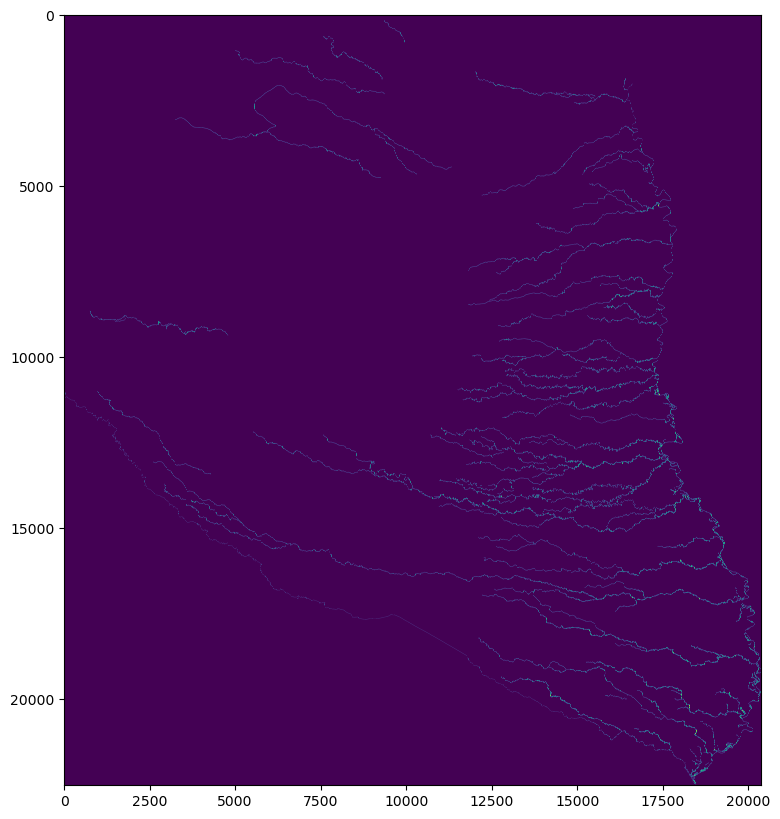

In [12]:
# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized_river, ax = ax)
plt.gca()

In [13]:
# Convert the rasterized array to boolean where True represents roads
river_mask = rasterized_river == 1

# Convert the lup_raster array to boolean where True represents the area of interest
area_mask = np.isin(lup_raster_array, [1, 2, 3, 4,5,6])

# Calculate the Euclidean distance from each road pixel to every other pixel
distances_river = distance_transform_edt(~river_mask)

# For pixels outside the area of interest, set the distance to a nodata value
distances_river[~area_mask] = -1

In [ ]:
# Where files will save, can add subfolders if desired
output_dir = os.path.join(DATA_PATH, 'processed_rasters', 'river_raster')
os.makedirs(output_dir, exist_ok=True)
output_filepath = os.path.join(output_dir, 'river_distance_raster.tif')

In [ ]:
# Write the rasterized data to a new GeoTIFF file
with rasterio.open(output_filepath, 'w', **profile) as dst:
    dst.write(distances_river.astype('float32'), 1)